# Monitor the Otimization Performance

It is crucial to keep a close eye on a training process after it has been started
- Training can take of order days to converge, so identifying issues early is a signifcant time and resource saver
- Models can overfit the data if given enough time, monitoring the performance on an intendependant (validation) set is essential to assess it

In this notebook we briefly touch on how to monitor the optimization process of a model
1. Find, open and read training log files
2. Use lartpc_mlreco3d validation routines to check for overtraining

<img src="https://miro.medium.com/max/1125/1*_7OPgojau8hkiPUiHoGK_w.png" alt="ARI" style="width: 800px;"/>

## 1. Train log files

For each training instance, a `.csv` log file is stored by `run.py` under the path specified in the configuration file every `X` iterations

```
trainval:
  log_dir: /sdf/group/neutrino/ldomine/chain/me/v04/log_trash
  report_step: 1
```

The name of the file is generated automatically under the requested folder with the form

```
train_log-0000000.csv
```

The number at the end specifies the iteration number when the file was created. If a training is resumed from an existing weight file, this number will be > 0.

### Visualization

Let us take a file from an existing folder, any training output will do

In [1]:
!ls /sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/train*

/sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/train_log-0000000.csv


In [2]:
log_path = '/sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/train_log-0000000.csv'

This a csv file, so you may read it using `Pandas`, or any other CSV reader of your choice:

In [3]:
import pandas as pd
train_log = pd.read_csv(log_path)
print('Number of rows', len(train_log))
train_log.keys()

Number of rows 70475


Index(['iter', 'first_id', 'epoch', 'titer', 'tsumiter', 'tio', 'tsumio',
       'mem', 'ttrain', 'tsave', 'tsumtrain', 'tsumsave', 'accuracy', 'loss',
       'accuracy_class_0', 'accuracy_class_1', 'accuracy_class_2',
       'accuracy_class_3', 'accuracy_class_4', 'ppn_acc', 'ppn_loss',
       'loss_class', 'loss_distance', 'loss_ppn1', 'loss_ppn2', 'acc_ppn1',
       'acc_ppn2', 'fraction_positives_ppn1', 'fraction_positives_ppn2',
       'fraction_negatives_ppn1', 'fraction_negatives_ppn2', 'acc_ppn_type',
       'loss_type', 'num_labels', 'num_discarded_labels_ppn1',
       'num_discarded_labels_ppn2', 'num_positives_ppn1', 'num_positives_ppn2',
       'uresnet_loss', 'uresnet_acc'],
      dtype='object')

This file contains one row for each iteration of the optimization process.

As you can see, there are a lot of columns in this file, some of which are common to any training campaign:
- `iter`: is the iteration number, i.e. the number of batches of data that have been processed
- `first_id`: is the id of the first entry in the batch
- `epoch`: is the iteration number divided by the total number of entries in the data file
- `titer`, `tio`, `ttrain`, `tsave`: are the times spent during this iteration in total (iter), on IO (io), on training (train) and on saving (save)
- `tsumiter`, `tsumio`, `tsumtrain`, `tsumsave`: are the total times spent on the above operations

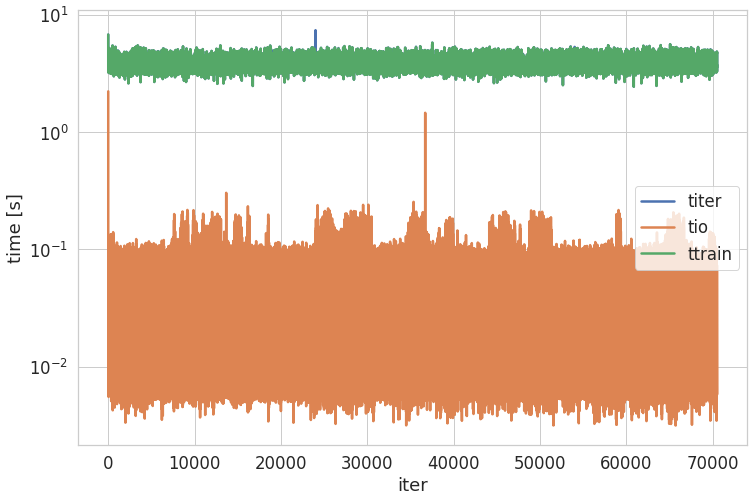

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(12, 8)})
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

train_log.plot('iter', ['titer', 'tio', 'ttrain'])
plt.ylabel('time [s]')
plt.yscale('log')
plt.show()

The rest of the parameters vary with the model specifications
- `accuracy`: represents the global accuracy (mean accuracy accross all models)
- `loss`: represents the sum of the losses across all modules
- The rest are module specific, and can be quite arcane
 - Working on implementing default behaviour as `{module}_{loss_name}_loss/accuracy`

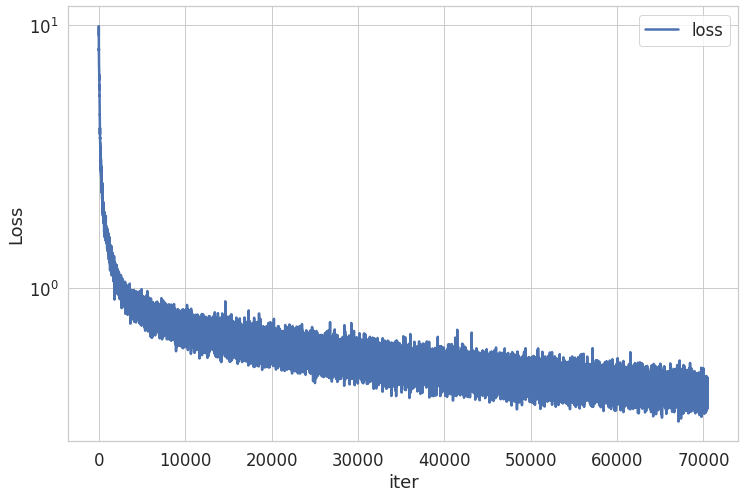

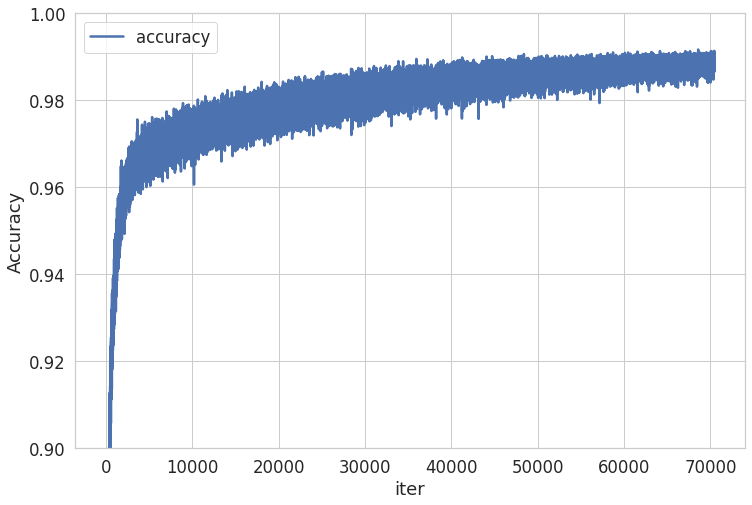

In [5]:
train_log.plot('iter', 'loss')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

train_log.plot('iter', 'accuracy')
plt.ylabel('Accuracy')
plt.ylim([0.9,1])
plt.show()

These two plots will show obvious issues, if there are any:
- If the loss does not go down at all, this indicates that the objective function is not being optimized properly
- If the scale of the loss/accuracy is significantly above/below the expectation, this also may indicate an issue

However, this is a very rough view of what is going on, only the validation set can truly tell us how the network will perform on an analysis

## 2. Validation set

If a deep neural network is given enough time, it might learn to make almost perfect predictions on the data set that it sees, at the expense of generalization...

For this reason, Machine Learning data sets are always separated between two (or three) datasets:
- A **training** set: labeled data the model sees during the objective function optimization
- A **validation** set: used to check whether the model is overtraining (i.e. overfitting the training set)
- A **test** set: used to evaluate the performance of a model optimized using the validation set

The second and third are one and the same in this example (~80% for training, ~20% for validation/test)
- If the network validation performance is not strongly iteration-dependant, it is ok

### Training checkpoints

During the training process, the `run.py` script records a weight file at every `X` iterations, as specified in the config file:

```
trainval:
  weight_prefix: /sdf/group/neutrino/ldomine/chain/me/v04/weights_trash/snapshot
  checkpoint_step: 500  
```

with names of the form

```
  snapshot-000499.csv
```

These contain the weights (fit parameters) for all the modules in the reconstruction chain.

One can use these weight files to check the performance of the algorithm at multiple stages of the optimization and confirm that the **validation set loss is not increasing**

### Validation

The `bin/run.py` script can **also** be used to do inference, i.e. to validate the performance on an independant dataset

The configuration simply needs to adapted to be used for validation:

```
iotool:
  sampler:
    SequentialBatchSampler
  data_keys:
    - path_to_validation_file
trainval:
  train: False
  iterations: 100
  model_path: /path/to/weight(s)
```

- The sequential sampler can be used so that the data that all the checkpoints see is the same
- The model_path supports wildcare to run inference on multiple weights sequentially

In [15]:
!python3 lartpc_mlreco3d/bin/run.py val_example.cfg

/usr/local/lib/python3.8/dist-packages/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(
val_example.cfg not found...


This process produces one validation log file per weight file, of the form

```
inference_log-0000000.csv
```

and stores it under the log file path. 

### Visualization

Let us take an existing inference log as an example

In [8]:
!ls /sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/inf*

/sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/inference_log-0001000.csv
/sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/inference_log-0002000.csv
/sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/inference_log-0003000.csv
/sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/inference_log-0004000.csv
/sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/inference_log-0005000.csv
/sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/inference_log-0006000.csv
/sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/inference_log-0007000.csv
/sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/inference_log-0008000.csv
/sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/inference_log-0009000.csv
/sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/inference_log-0010000.csv
/sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/inference_log-0011000.csv
/sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/infere

In [9]:
import glob

dir_path = '/sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/'
log_paths = glob.glob(dir_path+'/inf*')

Load up all the inference logs, get their iteration and the mean loss

In [10]:
import numpy as np

iterations = np.empty(len(log_paths), dtype=int)
losses = np.empty(len(log_paths))
for i, l in enumerate(log_paths):
    
    # Extract the iteration number from the name
    iterations[i] = int(l.split('-')[-1].split('.csv')[0])
    
    # Get the mean accuracy and loss
    val_log   = pd.read_csv(l)
    losses[i] = val_log['loss'].mean()

Load up the train log again, print the validation data points on top

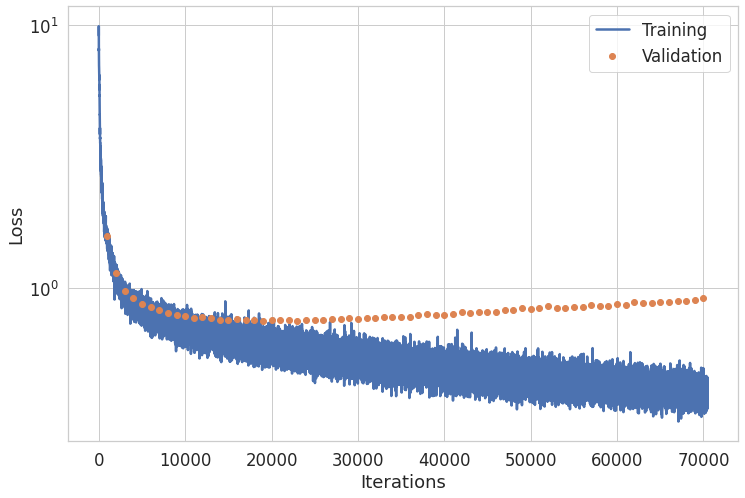

In [11]:
import pandas as pd

log_path = '/sdf/group/neutrino/drielsma/pi0/train/log/uresnet_ppn_v02/train_log-0000000.csv'
train_log = pd.read_csv(log_path)

plt.plot(train_log['iter'], train_log['loss'], label='Training')
plt.plot(iterations, losses, 'o', label='Validation')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

As you can tell from the above, the validation loss increases after ~20000 iterations, so there is no gain from training further

In [12]:
print('Best checkpoint iteration', iterations[np.argmin(losses)])
print('Best loss', np.min(losses))

Best checkpoint iteration 19000
Best loss 0.7532783999999999


## 3. Exercise

Train your own model (using Kazu's notebook as an example) and draw the training/validation loss as a function of iteration

In [13]:
# TODO